https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb

### Setup

In [12]:
import os

# PROJECT_ROOT_DIR = 'hands_on_ml/'
CHAPTER_ID = 'classification'
IMAGE_PATH = os.path.join('images', CHAPTER_ID)
os.makedirs(IMAGE_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + '.' + fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [17]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 dict구조를 갖는다.
- 데이터셋을 설명하는 DESCR
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data
- 레이블 배열을 담은 target

In [18]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [19]:
y.shape

(70000,)

70000개의 이미지가 있고 각 이미지엔 784개의 특성이 있다. 이미지가 28x28 픽셀이기 때문이다. \
개개의 특성은 단순히 0(흰색) ~ 255(검은색)까지의 픽셀강도를 나타낸다. \
데이터셋에서 이미지 하나를 확인해본다. 샘플의 특성 벡터를 추출해 28x28 배열로 크기를 바꾸고 matplotlib의 imshow() 함수를 사용해 그린다.

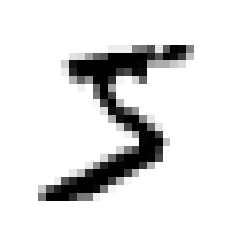

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis('off')
plt.show()

In [ ]:
y[0]

실제 레이블을 확인했을 때 위 그림과 숫자가 일치한다. 


레이블은 문자열이다. 대부분 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환한다.

In [21]:
import numpy as np

y = y.astype(np.uint8)

In [22]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis

In [23]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)

Saving figure more_digits_plot


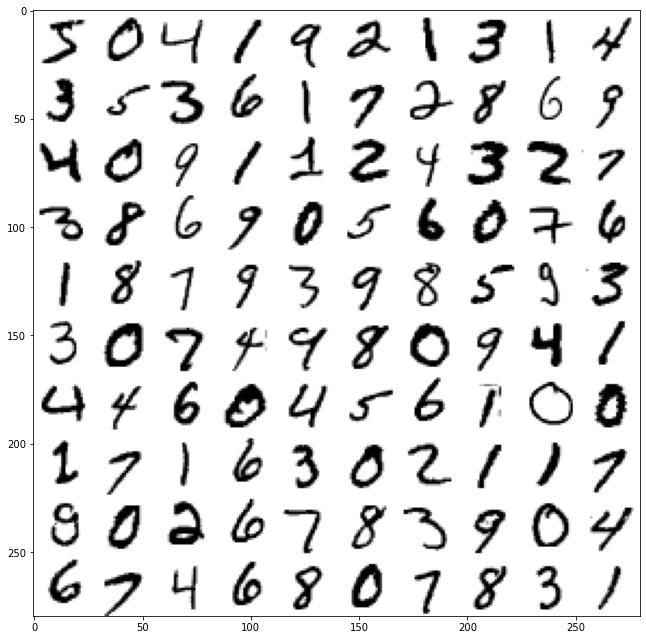

In [24]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig('more_digits_plot')
plt.show()

데이터를 들여다보기 전에 test_set을 만든다. MNIST dataset은 앞쪽 60000개와 뒤쪽 10000개로 훈련, 테스트세트를 나눠 둔다.

In [25]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

훈련 세트는 이미 섞여 있어, 모든 교차 검증 폴드를 비슷하게 만든다, 게다가 어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠진다. 이는 데이터셋을 섞음으로 방지할 수 있다.

## 1.이진 분류기 훈련
문제를 단순화해서 하나의 숫자(예:5)만 식별해보자. 이 '5-감지기'는 '5'와 '5가 아님' 두개의 클래스를 구분할 수 있는 **이진 분류기(binary classifier)**의 한 예이다. 분류 작업을 위해 타깃 벡터를 만들어본다.

In [26]:
y_train_5 = (y_train==5) # 5=True, else=False
y_test_5 = (y_test==5)

이제 분류 모델을 하나 선택해서 훈련시킨다. sklearn의 SGDClassifier 클래스를 사용한다. **확률적 경사 하강법(Stochastic Gradient Descent)**분류기는 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문에 매우 큰 데이터셋을 효율적으로 처리하는 장점을 지니고 있다. 

SGDClassifier 모델을 만들고 전체 훈련 세트를 사용해 훈련시킨다.

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

💡 SGDClassifier는 훈련하는 데 무작위성을 사용한다. 결과를 재현하고 싶다면 random_state를 지정해야 한다. 💡

이제 이 모델을 사용해 숫자 5의 이미지를 감지해본다.

In [15]:
sgd_clf.predict([some_digit])

array([ True])

분류기는 이 이미지가 5를 나타낸다고 추측했고, 정확히 맞췄다.

## 2.성능 측정

### 2-1.교차 검증을 사용한 정확도 측정

#### 2-1-1.교차 검증 구현
사이킷런이 제공하는 기능보다 교차 검증을 더 많이 제어해야 할 필요가 있으므로 교차 검증 기능을 직접 구현해야 한다. 다음 코드는 사이킷런의 cross_val_score() 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력한다.

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

0.9669
0.91625
0.96785


StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행한다. 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만든다. 그런 다음 올바른 예측의 수를 세어 정확한 예측의 비율을 출력한다.

cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델을 평가해본다. k-겹 교차 검증은 훈련 세트를 k(여기선 3개)개의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용한다.

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

모든 교차 검증 폴드에 대해 정확도가 95% 이상이다. 

모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교해본다.

In [18]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

모델의 정확도를 확인

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

정확도가 90%이상으로 나왔다. 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5아님'으로 예측하면 90%이다. 

위의 시도는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여준다. 특히 *불균형한 데이터셋* 즉, 어떤 클래스가 다른 것보다 월등히 많은 경우 더욱 그렇다.

### 2-2.오차 행렬
분류기의 다른 성능 평가 방법은 **오차 행렬(confusion matrix)** 을 조사하는 것이다. 기본적인 아이디어는 class A의 샘플이 class B로 분류된 횟수를 세는 것이다. 예를 들어 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면된다.

오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 한다. 테스트 세트로 예측을 만들 수 있지만 사용해선 안된다. 대신 cross_val_predict() 함수를 사용할 수 있다.

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_score() 함수처럼 cross_val_predict() 함수는 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환한다. 즉 모델이 훈련하는 동안 보지 못했던 데이터에 대한 예측을 얻게 된다.

이제 confusion_matrix() 함수를 사용해 오차 행렬을 만들 준비가 되었다. \
타깃 클래스(y_train_5)와 예측 클래스(y_train_pred)를 넣고 호출하면 된다.

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

오차 행렬의 행은 실제 클래스를 나타내고  열은 예측한 클래스를 나타낸다. \
이 행렬의 첫번째 행은 '5 아님'이미지(negative class)에 대한 것으로, 53892개를 '5 아님'으로 정확하게 분류했고(true negative) 나머지 687개는 '5'라고 잘못 분류했다.(false positive) \
두 번째 행은 '5'이미지(positive class)에 대한 것으로 1891개를 '5 아님'으로 잘못 분류했고(false negative) 나머지 3530개를 정확히 '5'라고 분류했다.(true positive) 왁벽한 분류기라면 진짜 양성과 진짜 음성만 가지고 있을 것이므로 오차 행렬의 주대각선만 0이 아닌 값이 된다.

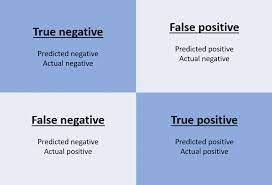
TP=진짜 양성의 수, TN=진짜 음성의 수 ,FP=거짓 양성의 수, FN=거짓 음성의 수

In [22]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기일 경우/
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

더욱 요약된 지표를 필요로 할 때 살펴볼만한 것은 양성 예측의 정확도이다. 이를 분류기의 **정밀도(precision)**라고 한다. 

정밀도 = TP / (TP + FP)

확실한 양성 샘플 하나만 예측하면 간단히 완벽한 정밀도(=1/1+0)를 얻을 수 있지만 이는 분류기가 다른 모든 양성 샘플을 무시하기 떄문에 그리 유용하지 않다. 정밀도는 **재현율(recall)**이라는 또 다른 지표와 같이 사용하는 것이 일반적이다. \
재현율은 분류기가 정확하게 감지한 양성 샘플의 비율로 **민감도(sensitivity)** 또는 **진짜 양성 비율(true positive rate)**이라고도 한다.

재현율 = TP / (TP + FN)

### 2-3.정밀도와 재현율
정밀도는 검색된 결과들 중 관련 있는 것으로 분류된 결과물의 비율이고\
재현율은 관련 있는 것으로 분류된 항목들 중 실제 검색된 항목들의 비율이다

sklearn은 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공한다.

In [23]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [24]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

이제 '5-감지기'가 정확도에서 봤을 때만큼 좋아보이지 않는다. 5로 판별된 이미지중 72.9%만 정확하고 전체 숫자 5에서 75.6%만 감지했다.

정밀도와 재현율을 **F1 score**라고 하는 하나의 숫자로 만들면 편리하다. F1점수는 정밀도와 재현율의 **조화 평균(harmonic mean)**이다.
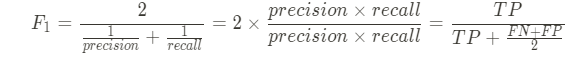

F1 점수를 계산하려면 f1_score() 함수를 호출한다.

In [25]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷한 분류기에선 F1 점수가 높다. 하지만 상황에 따라 정밀도가 중요하거나 재현율이 중요할 수도 있다. \
예를 들어 아이를 위해 안전한 동영상을 걸러내는 분류기를 훈련할때, 재현율은 높으나 나쁜 동영상도 몇개 노출되는 것보단, 낮은 재현율로 좋은 동영상이 몇개 제외되더라도 안전한 것들만 노출시키는 높은 정밀도의 분류기가 선호된다.\
그에 비해 도둑을 잡아내는 분류기를 훈련할때, 분류기의 재현율이 99%라면 정확도가 30%만 되더라도 괜찮을지도 모른다.

이처럼 정밀도와 재현율이 반비례하는 것을 **정밀도/재현율 트레이드오프**라고 한다.

### 2-4.정밀도/재현율 트레이드오프
SGDClassifier는 **결정 함수(decision function)**을 사용하여 각 샘플의 점수를 계산한다. 이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고 반대론 음성 클래스에 할당한다. 

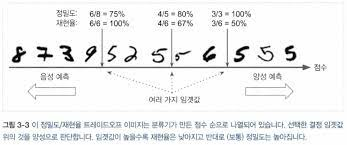

위 사진에서 가운데 화살표가 **결정 임곗값(decision threshold)**일 때 임곗값 오른쪽에 4개의 TP가 있고 1개의 FP가 있기에 정밀도는 4/(4+1)=80%가 된다. 하지만 TP는 4개고 FP는 2개 이므로 4/(4+2)=67%이다. \
임곗값을 오른쪽으로 옮기면 FP인 '6'이 TN이 되므로 정밀도가 3/(3+0)=100%가 된다. 하지만 TP하나가 FN가 되며 재현율이 3/(3+3)=50%로 줄어든다.

사이킷런에서 임곗값을 직접 지정할 순 없지만 예측에 사용한 점수는 확인할 수 있다. 분류기의 predict() 메서드 대신 decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있다. 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있다.

In [26]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [27]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([ True])

In [28]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([False])

위의 threshold(임곗값)을 바꿔가며 계산한 것으로 임곗값을 높이면 재현을이 줄어든다는 것을 알 수 있다. 

적절한 임곗값을 찾기 위해 cross_val_predict()함수를 사용해 훈련 세트에 있는 모든 샘플의 정수를 구해야한다. 하지만 이번에는 예측 결과가 아닌 결정 점수를 반환받도록 지정해야한다.

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method='decision_function')

In [30]:
y_scores.shape

(60000,)

In [31]:
if y_scores.ndim == 2:
    y_scores = y_scores[:,1]

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


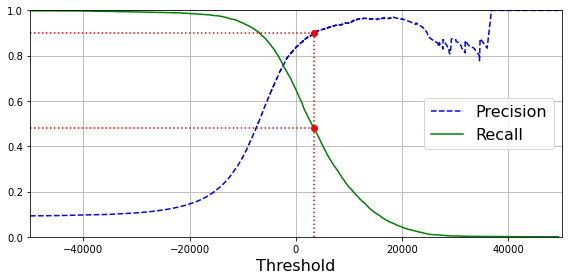

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc='center right', fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], 'r:')
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], 'r:')
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], 'r:')
plt.plot([threshold_90_precision], [0.9], "ro")     
plt.plot([threshold_90_precision], [recall_90_precision], "ro")       

save_fig("precision_recall_vs_threshold_plot")
plt.show()

정밀도 최소 90% 달성이 목표라면 그래프에서 약 8000정도라고 볼 수 있고 아래의 코드로 정확한 가장 낮은 임곗값을 알 수 있다. 

In [34]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

훈련 세트에 대한 예측을 만들기 위해 분류기의 predict() 메서드 대신 다음 코드를 실행한다.

In [35]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

이제 예측에 대한 정밀도와 재현율을 확인해본다

In [36]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [37]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

좋은 정밀도/재현율 트레이드오프를 선택하는 다른 방법은 재현율에 대한 정밀도 곡선을 그리는 것이다.


Saving figure precision_vs_recall_plot


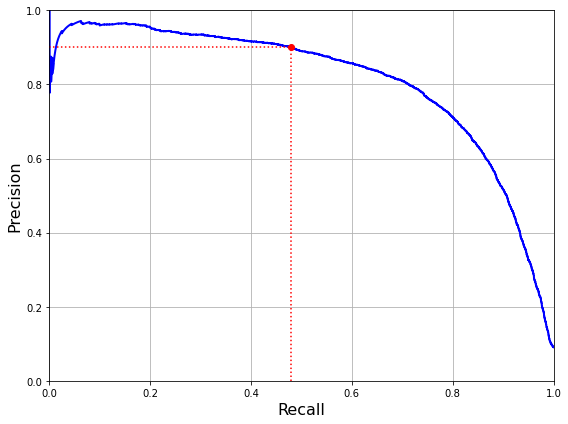

In [38]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")

save_fig('precision_vs_recall_plot')
plt.show()

 재현율 80% 근처에서 정밀도가 급격히 준다. 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다. 

### 2-5. ROC 곡선

**수신기 조작 특성(Receiver Operating Characteristic, ROC)**곡선도 이진 분류에서 널리 사용된다. 이는 **거짓 양성 비율(FP Rate)**에 대한 **진짜 양성 비율(TPR)**의 곡선이다. FPR은 1에서 **진짜 음성 비율(TNR)**을 뺀 값이다. TNR은 **특이도(specificity)**라고도 한다. 따라서 ROC 곡선은 **민감도**(재현율)에 대한 **1-특이도** 그래프이다.

ROC 곡선을 그리기 위해 roc_curve() 함수를 이용해 여러 임곗값에서 TPR과 FPR을 계산해야 한다.

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


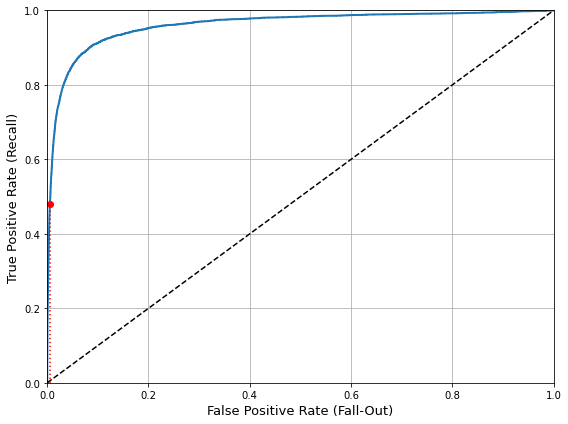

In [40]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=13)
    plt.ylabel('True Positive Rate (Recall)', fontsize=13)
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
save_fig("roc_curve_plot")                                    
plt.show()

(붉은 점이 선택한 비율의 지점이다. 43.68%의 재현율)\
이곳에서도 트레이드오프가 있다. 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어난다. 점선은 완전한 *랜덤 분류기의 ROC곡선을 뜻한다. 이 점선에서 가장 멀리 떨어져 있는 것이 좋은 분류기이다.

`*랜덤 분류기는 훈련 데이터의 클래스 비율을 따라 무작위로 예측하는 것을 말한다. 이렇게 되면 오차 행렬의 실제 클래스가 비슷한 비율의 예측 클래스로 나뉘어 FPR과 TPR 값이 비슷해진다.` 

곡선 아래의 면적(AUC)을 측정하면 분류기들을 비교할 수 있다. ROC의 AUC가 1이면 완벽한 분류기, 0.5면 완전한 랜덤 분류기이다. roc_auc_score를 이용해 ROC의 AUC를 계산한다.

In [41]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC곡선과 ROC AUC 점수를 비교한다. 먼저 훈련 세트의 샘플에 대한 점수를 얻어야한다, \
RandomForestClassifier는 decision_function() 메서드 대신 predict_proba() 메서드가 있다. 이는 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환한다. 

In [42]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                   method='predict_proba')

roc_curve() 함수에 점수 대신 클래스 확률을 전달할 수 있다. 양성 클래스 확률을 점수로 사용해본다.

In [43]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

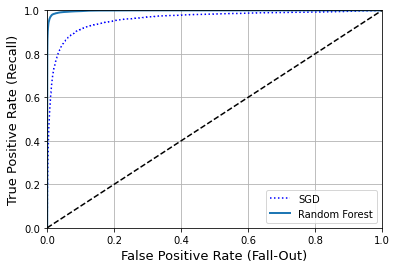

In [44]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

RandomForestClassifier의 ROC곡선이 왼쪽 위 모서리에 더욱 가깝기에 SGDClassifier보다 좋다고 판단할 수 있다.

In [45]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

당연히 ROC의 AUC도 높다. 

## 3. 다중 분류

다중 분류기(multiclass classifier)또는 다항 분류기(multinormial classfier)는 둘 이상의 클래스를 구별할 수 있다.

SGD, Random Forest, Naive Bayes 등 은 여러개의 클래스를 직접 처리할 수 있는 반면 Logistic Regression, SVM 등은 이진 분류만 가능하다. 하지만 여러개 사용해 다중 클래스를 분류하는 기법도 있다. \
예를 들어 이진 분류기 10개를 사용해 0~9까지를 훈련시켜 클래스가 10개인 숫자 이미지 분류가 가능하며, 분류기의 결정 점수 중 가장 높은 것을 클래스로 선택하면 된다.(이를 OvR이라고 한다) \
또한 0과 1 구별, 1과 2 구별 등 각 숫자의 조합마다 이진 분류기를 훈련시키는 방식도 있다.(이를 OvO라고 한다, N개의 클래스라면 Nx(N-1)/2개의 분류기가 필요하다.)

SVM은 훈련 세트의 크기에 민감해서 작은 훈련 세트에서 많은 분류기를 훈련시키는 것이 빠르므로 OvO가 유리하다. (하지만 대부분의 이진 분류기는 OvR이 유리하다)

다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR또는 OvO를 실행한다. 

svm을 테스트해본다.

In [46]:
from sklearn.svm import SVC
svm_clf = SVC(gamma='auto', random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])

svm_clf.predict([some_digit])

array([5], dtype=uint8)

이 코드는 0~9까지의 타깃 클래스를 사용해 SVD를 훈련시킨 뒤 예측을 만든다.(모델이 5라고 정확히 맞추었다.) 이는 내부적으로 OvO전략을 사용해 45개의 이진 분류기를 훈련시켜 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택한다.  

decision_function()을 호출히면 클래스마다 한개씩 10개의 점수를 반환한다. 

In [47]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [48]:
np.argmax(some_digit_scores)

5

In [49]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [50]:
svm_clf.classes_[5]

5

사이킷런에서 OvO, OvR을 강제로 사용하도록 하려면 OneVsOneClassifier 혹은 OneVsRestClassifier를 사용한다. 

위 코드는 SVC기반으로 OvR전략을 사용한다.

In [51]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])

ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [52]:
len(ovr_clf.estimators_)

10

SGDClassifier를 훈련시킨다.

In [53]:
sgd_clf.fit(X_train[:1000], y_train[:1000])
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

이 경우 SGD분류기는 직접 샘플을 다중 클래스로 분류할 수 있기에 별도로 OvR, OvO를 적용할 필요가 없다.

In [54]:
sgd_clf.decision_function([some_digit])

array([[-6049581.97985829, -6138036.45541781, -3886281.38604605,
         -604692.42366776, -6948311.32017537,   914498.2913215 ,
        -6855666.78647961, -3866146.33271573, -4016434.08430155,
        -3209136.89074954]])

위 결과에서 대부분의 점수가 큰 음수인 반면 클래스 5의 점수는 914498점이다. 

이제 분류기를 평가해야 하는데 주로 교차 검증이 사용된다.

In [55]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

모든 테스트 폴드에서 84%이상이다. 입력의 스케일을 조정하면 정확도를 89%이상으로 높일 수 있다. 

In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## 4. 에러 분석

가능성이 높은 모델을 하나 찾았다고 가정한다. 이 모델의 성능을 향상시킬 방법을 찾을 때 만들어진 에러의 종류를 분석하는 방법이 있다.

먼저 오차 행렬을 살펴볼 수 있다.

In [57]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

5인 것을 5로 분류한 것이 4484개로, 알맞게 분류한 것 중 가장 작다.

오차 행렬은 matshow()로 이미지로 표현하면 보기 편하다. (배열에서 큰 값은 흰색, 작은 값은 검은색으로 정규화되어 그려진다.)

Saving figure confusion_matrix_plot


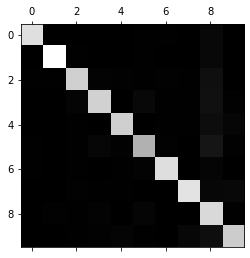

In [58]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

이 오차 행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주 대각선에 있다. 숫자 5는 상대적으로 어두워 보인다. 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 5를 잘 분류하지 못한다는 뜻이다. 

이제 그래프의 에러 부분에 초점을 맞춰서, 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나눠 에러 비율을 비교한다. 

In [67]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

주대각선만 0으로 채워 그래프를 그린다. 

Saving figure confusion_matrix_errors_plot


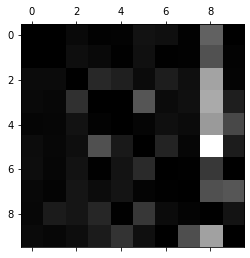

In [68]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

이 오차 행렬에서 분류기가 만든 에러를 확실히 볼 수 있다. row는 실제 클래스를 나타내고 column은 예측한 클래스를 나타낸다. 8의 column이 밝으므로 많은 이미지가 8로 잘못 분류되었음을 알 수 있다. 하지만 8의 row는 밝지 않으므로 8이 적절히 8로 분류되었음을 알 수 있다. \
또한 3과 5가 서로 혼동되고 있는 것도 볼 수 있다.

오차 행렬을 분석하므로 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있다. 예를 들어 위 그래프에선 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있다. 8처럼 보이는 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습할 수 있다. \
또는 분류기에 도움 될만한 특성(동심원, 이미지 전처리)을 더 찾아볼 수도 있다.

개개의 에러를 분석해보면 분류기가 무슨 일을 하고, 왜 잘못되었는지에 대한 통찰을 얻을 수 있지만, 시간이 오래걸린다. 3과 5의 샘플을 그려본다.

Saving figure error_analysis_digits_plot


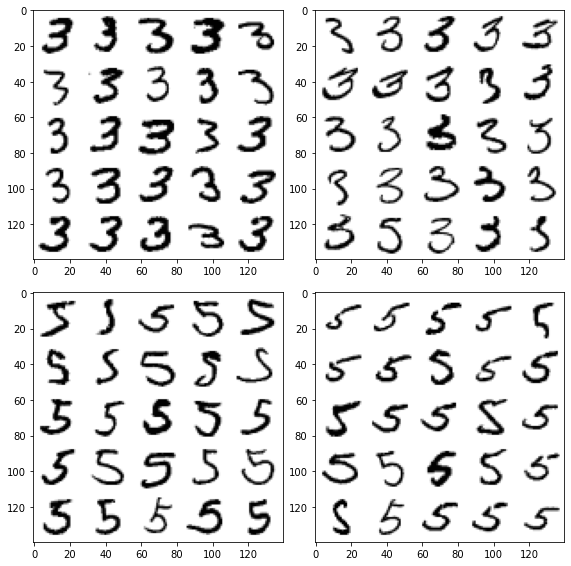

In [69]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # 3을 3으로 분류
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # 3을 5로 분류
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # 5를 3으로 분류
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # 5를 5로 분류

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

왼쪽의 5x5블록 두 개는 3으로 분류된 이미지, 오른쪽은 5로 분류된 이미지이다.

왼쪽 아래, 오른쪽 위의 대부분의 이미지들은 분류기가 잘못 분류한 것이 이해가 되지 않는다. \
이는 SGDClassifier를 사용했기 때문인다. 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산한다. 따라서 3과 5는 몇개의 픽셀만 다르기에 모델이 혼동할 수 밖에 없다.


## 5. 다중 레이블 분류

분류기가 샘플마다 여러개의 클래스를 출력해야할 때 **다중 레이블 분류(multilabel classification)**시스템을 사용한다.

In [63]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

위 코드는 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열을 만든다. 첫 번째는 숫자가 큰 값(7,8,9)인지 나타내고 두 번째는 홀수인지 나타낸다. 

이제 예측을 만들면 레이블이 두 개 출력된다.

In [64]:
knn_clf.predict([some_digit])

array([[False,  True]])

5는 크지 않고 홀수이므로 올바른 분류이다. 

다중 레이블 분류기의 평가를 위해 각 레이블의 F1점수를 구하고 평균점수를 계산할 수 있다. 

In [66]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

위 코드는 모든 레이블의 가중치가 같다고 가정했다. \
average='weighted'로 설정하면 레이블에 클래스의 타깃 레이블에 속한 샘플 수(support)를 가중치로 준다.

## 6. 다중 출력 분류

**다중 출력 분류(multioutput classification)**작업은 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것이다.

이를 위해 이미지에서 잡음을 제거하는 것이 필요하다. 잡음이 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력한다. 분류기의 출력이 다중 레이블이고 각 레이블은 값을 여러개 갖는다. 그러므로 다중 출력 분류 시스템이 된다.

먼저 MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이의 randint()를 사용해 픽셀 강도에 잡음을 추가한다. 

In [73]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


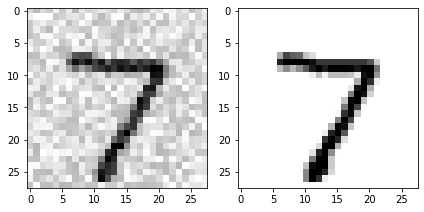

In [75]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig('noisy_digit_example_plot')
plt.show()

분류기를 훈련시켜 께끗하게 만든다.

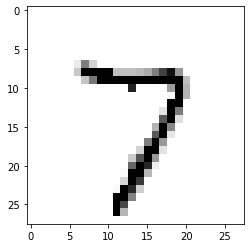

In [76]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

타깃 즉, 께끗한 이미지와 비슷하다. 

# 추가 내용

### Dummy(ie, random) classifier

In [77]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier(strategy='prior')
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_dmy = y_probas_dmy[:, 1]

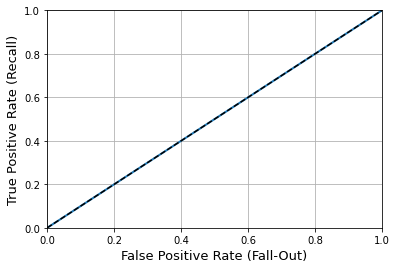

In [78]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

### KNN Classifier

In [79]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [80]:
y_knn_pred = knn_clf.predict(X_test)

In [81]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

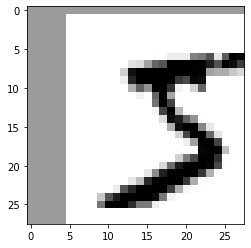

In [82]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [83]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [84]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [85]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [86]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [88]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

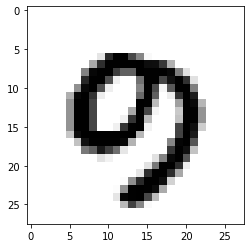

In [89]:
plot_digit(ambiguous_digit)

# 📏연습 문제 풀어보기

#### 정확도 97%이상 달성

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{'weights': ['uniform', 'distance'], 'n_neighbors':[3,4,5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .................n_neighbors=3, weights=uniform; total time=  39.3s
[CV 2/5] END .................n_neighbors=3, weights=uniform; total time=  43.9s
[CV 3/5] END .................n_neighbors=3, weights=uniform; total time=  43.5s
[CV 4/5] END .................n_neighbors=3, weights=uniform; total time=  43.5s
[CV 5/5] END .................n_neighbors=3, weights=uniform; total time=  36.1s
[CV 1/5] END ................n_neighbors=3, weights=distance; total time=  33.4s
[CV 2/5] END ................n_neighbors=3, weights=distance; total time=  32.6s
[CV 3/5] END ................n_neighbors=3, weights=distance; total time=  32.3s
[CV 4/5] END ................n_neighbors=3, weights=distance; total time=  32.0s
[CV 5/5] END ................n_neighbors=3, weights=distance; total time=  31.8s
[CV 1/5] END .................n_neighbors=4, weights=uniform; total time=  38.3s
[CV 2/5] END .................n_neighbors=4, weig

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [28]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [29]:
grid_search.best_score_

0.9716166666666666

In [30]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

#### 데이터 증식, 훈련 세트 확장
MNIST이미지를 어느 방향으로든 한 픽셀 이동시키는 함수를 만들고, 훈련 세트에 있는 각 이미지에 네 개의 이동된 복사본을 만들어 훈련세트에 추가한다. 이를 위의 최선의 모델에 훈련시켜 정확도를 측정해보라

In [31]:
from scipy.ndimage.interpolation import shift

In [50]:
def shift_image(image, dx, dy):
    image = image.reshape((28,28))
    shifted_image = shift(image, [dy, dx], cval=0, mode='constant')
    return shifted_image.reshape([-1])

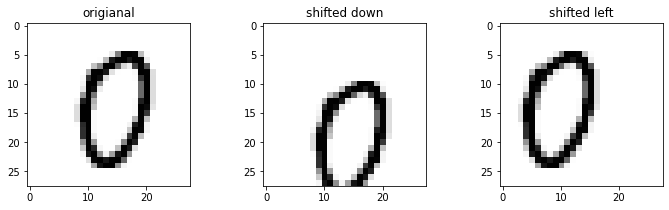

In [51]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.title('origianal')
plt.imshow(image.reshape(28,28), interpolation='nearest', cmap='Greys')

plt.subplot(132)
plt.title('shifted down')
plt.imshow(shifted_image_down.reshape(28,28), interpolation='nearest', cmap='Greys')

plt.subplot(133)
plt.title('shifted left')
plt.imshow(shifted_image_left.reshape(28, 28), interpolation='nearest', cmap='Greys')
plt.show()

In [52]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [53]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [55]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [56]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [57]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

### 타이타닉 데이터셋

In [2]:
import os

TITANIC_PATH = os.path.join('datasets','titanic')

In [3]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [4]:
train_data =load_titanic_data('train.csv')
test_data =load_titanic_data('test.csv')

In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- Survied: target이다. 
- Pclass: 승객 클래스
- SibSp: 함께 탑승한 형제자매와 배우자 수
- Parch: 함께 탑승한 자녀와 부모
- Ticket: 티켓 아이디
- Fare: 지불한 금액
- Cabin: 객실 번호
- Embarked: 탑승한 곳

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Name과 Tiket은 모델이 사용하기에 유용한 숫자로 변환하는데 까다롭기 때문에 무시한다.

In [7]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- 38%정도 밖에 생존하지 못했다.
- 금액의 평균은 32.20파운드이다. 
- 나이 평균은 30보다 아래다.

In [9]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [10]:
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [11]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [12]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Embarked의 SCQ는 각각 Southampton, Cherbourg, Queenstown이다.

### preprocessing pipeline building

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(['Age', 'SibSp', 'Parch','Fare'])),
    ('Imputer', SimpleImputer(strategy='median')),
])

In [18]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [21]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                       index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [22]:
from sklearn.preprocessing import OneHotEncoder

In [23]:
cat_pipeline = Pipeline([
    ('select_cat', DataFrameSelector(['Pclass', 'Sex', 'Embarked'])),
    ('imputer', MostFrequentImputer()),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

In [24]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [25]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [26]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [27]:
y_train = train_data['Survived']

ready to classifier. Let's start SVC

In [28]:
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto')
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

In [31]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

cross val 수행

In [32]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

80%정도는 넘겨야 되지 않냐?ㅋ

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

10개의 fold들 정확도의 평균을 보는 것보다. 모델의 10개의 점수에 대해 plot을 그린다.

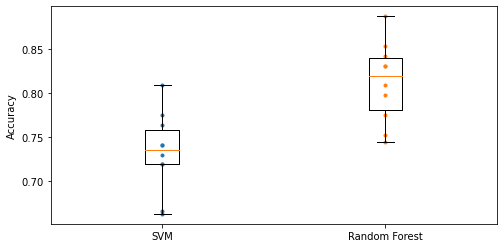

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot([1]*10, svm_scores, '.')
plt.plot([2]*10, forest_scores, '.')
plt.boxplot([svm_scores, forest_scores], labels=('SVM', 'Random Forest'))
plt.ylabel('Accuracy')
plt.show()

In [39]:
train_data['AgeBucket'] = train_data['Age'] // 15 * 15
train_data[['AgeBucket', 'Survived']].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [41]:
train_data['RelativesOnboard'] = train_data['SibSp'] + train_data['Parch']
train_data[['RelativesOnboard', 'Survived']].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


### Spam classifier

In [1]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (('ham.tar.bz2', ham_url), ('spam.tar.bz2', spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()
        
        
fetch_spam_data()

In [2]:
HAM_DIR = os.path.join(SPAM_PATH, 'easy_ham')
SPAM_DIR = os.path.join(SPAM_PATH, 'spam')
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [3]:
len(ham_filenames)

2500

In [4]:
len(spam_filenames)

500

In [5]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = 'spam' if is_spam else 'easy_ham'
    with open(os.path.join(spam_path, directory, filename), 'rb') as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [8]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

데이터의 생김새를 보기 위해 스팸과 햄의 한가지 예시들을 본다

In [9]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [10]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


이메일은 이미지 첨부파일이 있는 이메일도 있다. 이제 다양한 메일의 구조들을 살펴본다.

In [11]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(', '.join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [12]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1 
    return structures

In [13]:
structures_counter(han_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [22]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

spam은 HTML로 이 많은 반면 ham이메일은 plain text로 보인다. \
게다가 꽤 많은  ham 이메일들은 PGP를 이용해서 서명한다. 하지만 스팸은아니다. 

In [24]:
for header, value in spam_emails[0].items():
    print(header, ':', value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

focus on the Subject header

In [25]:
spam_emails[0]['Subject']

'Life Insurance - Why Pay More?'

In [26]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

이제 전처리 함수를 만들 차례다. 처음으로 beatifulSoup lib을 이용해 HTML을 plain text로 변환한 함수를 만든다. 하지만 의존성을 추가하고 싶지 않고 싶으므로 정규 표현식을 사용한다. 

다음 함수는 \<head> 섹션을 삭제한 다음 모든 \<a>태그를 하이퍼링크로 변환한 뒤 모든 HTML 태그를 제거하고 plain 텍스트만 남긴다. 또한 여러줄은 한 줄로 대체하고 HTML entities를 제거한다.

In [34]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [35]:
# html sapm

html_spam_emails = [email for email in X_train[y_train==1]
                   if get_email_structure(email) == 'text/html']
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [36]:
# resulting plain text

print(html_to_plain_text(sample_html_spam.get_content())[:1000], '...')


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

이제 email을 input으로 받고 plain text로 return해주는 함수를 정의해보자, 

In [37]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ('text/plain', 'text/html'):
            continue
        try:
            content = part.get_content()
        except:
            content = str(part.get_payload())
        if ctype == 'text/plain':
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [38]:
print(email_to_text(sample_html_spam)[:100], '...')


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...
